# Iteration 1 - YOLOv8m Table Detector Model

> **Dataset**: Marmot Dataset <br/>
> **Model**: YOLOv8m Table Detector<br/>
> **Creator**: Ryo

### Install Additional Packages

- **tesseract-ocr**: `tesseract-ocr` is an open-source Optical Character Recognition (OCR) engine developed by Google. Installing it via `!sudo apt install tesseract-ocr` allows the system to use Tesseract to convert images of text into machine-readable text. It is commonly used in tasks such as document digitization, table recognition, and image-to-text conversion.

- **pytesseract**: `pytesseract` is a Python binding for Tesseract-OCR. By installing `pytesseract`, you can integrate Tesseract OCR functionality directly into your Python scripts. This library simplifies the process of running Tesseract OCR in Python to extract text from images.

- **transformers**: `transformers` is a Python library developed by Hugging Face, designed for state-of-the-art Natural Language Processing (NLP) tasks using Transformer models like BERT, GPT, and T5. Installing this allows you to leverage pre-trained models and architectures to handle a variety of language understanding tasks such as text classification, text generation, and translation.

- **ultralyticsplus==0.0.23**: `ultralyticsplus` is a Python package built on top of the `ultralytics` library, providing additional features and models for object detection and segmentation, including support for YOLO models. By installing version `0.0.23`, you can access functionalities like model loading, fine-tuning, and inference for computer vision tasks.

- **ultralytics==8.0.21**: `ultralytics` is a package developed by Ultralytics for training, deploying, and running YOLO (You Only Look Once) object detection models. This library provides a straightforward interface for working with YOLOv5 and YOLOv8 models in Python. Installing version `8.0.21` allows you to access object detection models for detecting objects, tables, and bounding boxes within images.

In [1]:
# %pip install -q pytesseract transformers ultralyticsplus ultralytics timm

In [2]:
# %pip install -q git+https://github.com/huggingface/transformers.git

### Import Libraries

In [94]:
# Essential libraries
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
import plotly.graph_objects as go

# OCR and image processing libraries
import pytesseract
from pytesseract import Output
import cv2
from PIL import Image, ImageEnhance, ImageFilter

# YOLO object detection and rendering
from ultralyticsplus import YOLO, render_result
from transformers import DetrFeatureExtractor, TableTransformerForObjectDetection

# PyTorch
import torch

# Text matching and comparison
import difflib
import re
from pathlib import Path

#### *Settings*

In [4]:
# Specify the Tesseract command location for Windows
pytesseract.pytesseract.tesseract_cmd = r'D:\Software\Tesseract-OCR\tesseract.exe'

# Display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Global Variables

In [45]:
# Path to the folder containing images
base_folder = '../data'
image_folder = os.path.join(base_folder, 'improved')

## **Data Collection**

### Load Random Image

#### *Function*

In [6]:
def load_random_image_from_folder(image_folder):
    """
    Load one random image from the specified folder.

    Parameters:
        image_folder (str): The path to the folder containing images.

    Returns:
        numpy.ndarray: The randomly selected image as a NumPy array, or None if no image is found.
    """
    # Step 1: Convert the image folder path to a Path object for easier handling
    image_folder = Path(image_folder)

    # Step 2: Check if the folder exists and is indeed a directory
    if not image_folder.is_dir():
        print(f"Error: The folder '{image_folder}' does not exist or is not a directory.")
        return None

    # Step 3: Define the allowed image file extensions (case-insensitive)
    image_extensions = {'.jpg', '.jpeg', '.png'}

    # Step 4: Collect all image files in the folder with the allowed extensions
    image_files = [
        file for file in image_folder.iterdir()
        if file.suffix.lower() in image_extensions
    ]

    # Step 5: Check if any image files were found
    if not image_files:
        print("Error: No image files found in the folder.")
        return None

    # Step 6: Randomly select one image from the list of image files
    random_image = random.choice(image_files)

    # Step 7: Open the image and ensure it is in RGB format
    img = Image.open(random_image).convert("RGB")

    # Step 8: Convert the image to a NumPy array for compatibility with other libraries
    img_array = np.array(img)

    # Step 9: Return the image array
    return img_array

#### *Implementation*

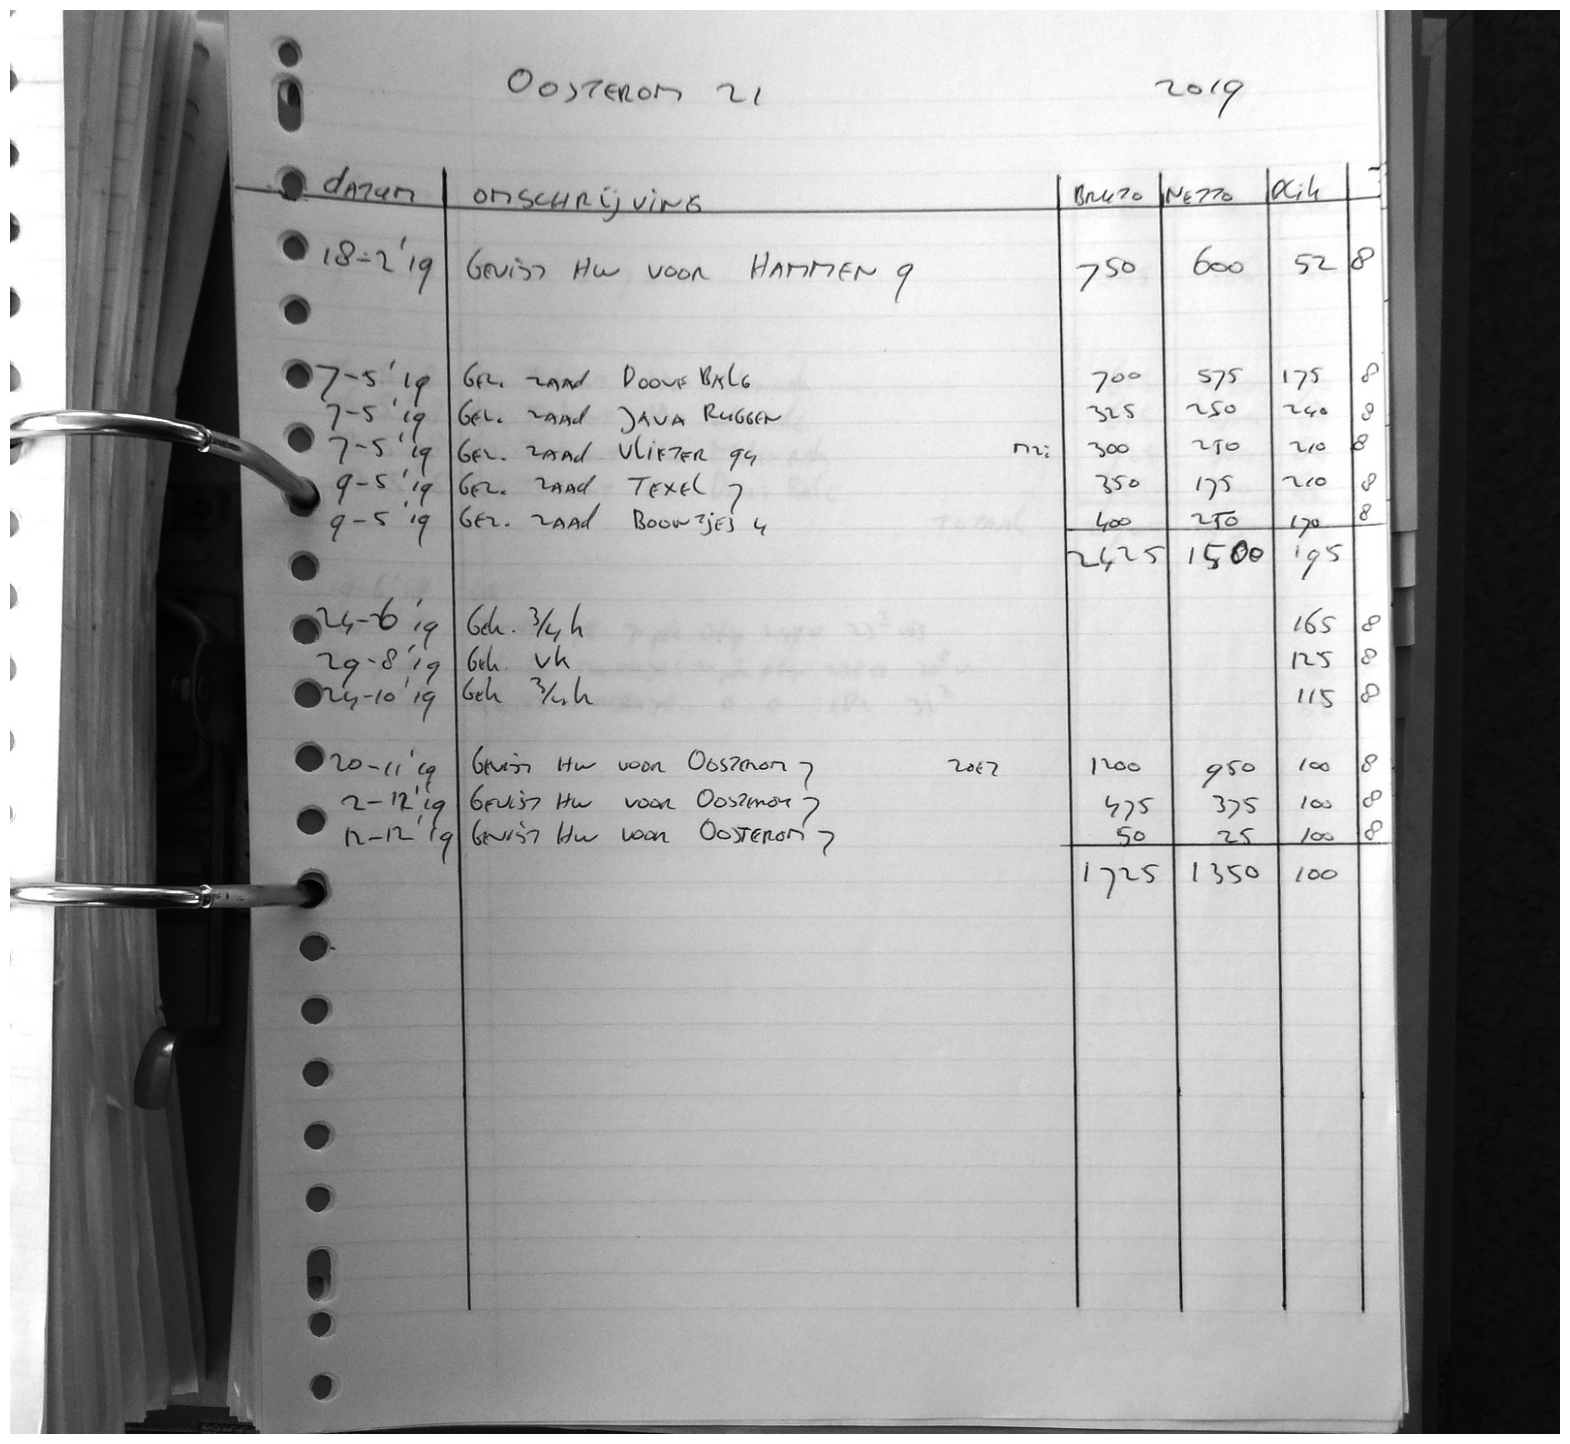

In [48]:
# Load one random image from the folder
img = load_random_image_from_folder(image_folder)

# If an image was successfully loaded, display it
if img is not None:
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes for a cleaner look
    plt.show()
else:
    print("No image to display.")

## **Modeling 1 - YOLOv8m Table Detection**

### YOLOv8m Model

#### *Explanation*

YOLOv8m (You Only Look Once, version 8 medium) is a model specifically designed for object detection tasks, including table detection. Here's a simplified explanation:

- **YOLOv8m Overview**: YOLOv8m is part of the YOLO family of models, which are popular for real-time object detection because of their speed and accuracy. The "m" in YOLOv8m stands for "medium," indicating it's a balance between model size and performance compared to larger (YOLOv8l) or smaller (YOLOv8s) models.

- **Table Detection with YOLOv8m**: When used for detecting tables, YOLOv8m can quickly scan an image and predict the location of tables by drawing bounding boxes around them. This is useful in tasks like document analysis, where you want to automatically detect and extract tables from images or scanned documents.

- **How It Works**:
  1. **Input**: You provide an image (e.g., a scanned document or a photo containing tables).
  2. **Detection**: YOLOv8m identifies and draws bounding boxes around any tables present in the image.
  3. **Output**: The model returns the coordinates of the detected tables, which can then be used for further processing, such as extracting table data using OCR.

- **Use Case**: YOLOv8m is used in applications where you need to detect multiple tables in documents or images quickly, making it ideal for scenarios like automated data extraction from PDFs, invoices, or reports.

#### *Initialize Model*

In [40]:
# Load the YOLO model for table extraction
model_yolo = YOLO('keremberke/yolov8m-table-extraction')

# Set model parameters
model_yolo.overrides['conf'] = 0.05   # Lower confidence threshold
model_yolo.overrides['iou'] = 0.35    # Lower IoU threshold
model_yolo.overrides['max_det'] = 3000  # Increase max detections
model_yolo.overrides['agnostic_nms'] = True  # Class-agnostic NMS

#### *Parameter Explanations*

- **`conf`: NMS confidence threshold**
  - **Description**: Sets the minimum confidence score required for a detection to be considered valid. Predictions with confidence below this threshold will be discarded.
  - **Example**: `0.25` means detections must have at least 25% confidence to be kept.

- **`iou`: NMS IoU threshold**
  - **Description**: Defines the Intersection over Union (IoU) threshold used in Non-Maximum Suppression (NMS). It controls how much overlap between detected objects is allowed before they are considered duplicates and one is suppressed.
  - **Example**: `0.45` allows up to 45% overlap between boxes before suppressing.

- **`agnostic_nms`: NMS class-agnostic**
  - **Description**: If set to `True`, Non-Maximum Suppression (NMS) will ignore class labels when suppressing overlapping boxes, treating all classes the same. If `False`, it will suppress only overlapping boxes of the same class.
  - **Example**: `False` means that class labels will be considered in the NMS process.

- **`max_det`: Maximum number of detections per image**
  - **Description**: Specifies the maximum number of detections the model can return for a single image. This prevents the model from returning an excessive number of detections.
  - **Example**: `1000` allows up to 1000 detections to be returned per image.

### Crop Image

#### *Function*

In [77]:
# List to store cropped tables
cropped_tables = []

In [73]:
def crop_tables_from_image(image, left_padding=10, right_padding=15, top_padding=10, bottom_padding=10):
    """
    Crop the image with specified padding values, focusing on cutting out the left side and applying the padding.

    Parameters:
        image (numpy.ndarray): The input image to be cropped.
        left_padding (int): The amount of padding to add to the left side of the image.
        right_padding (int): The amount of padding to add to the right side of the image.
        top_padding (int): The amount of padding to add to the top side of the image.
        bottom_padding (int): The amount of padding to add to the bottom side of the image.

    Returns:
        numpy.ndarray: Cropped image with applied padding.
    """
    # Get the image dimensions (height and width)
    height, width = image.shape[:2]

    # Calculate new coordinates with padding
    x1 = max(0, left_padding)           # Apply left padding
    y1 = max(0, top_padding)            # Apply top padding
    x2 = min(width, width - right_padding)  # Apply right padding
    y2 = min(height, height - bottom_padding) # Apply bottom padding

    # Crop the image using the adjusted coordinates
    cropped_image = image[y1:y2, x1:x2]

    # Return the cropped image
    return cropped_image

#### *Implementation*

Cropping the image with custom padding...
Cropping of the image completed.


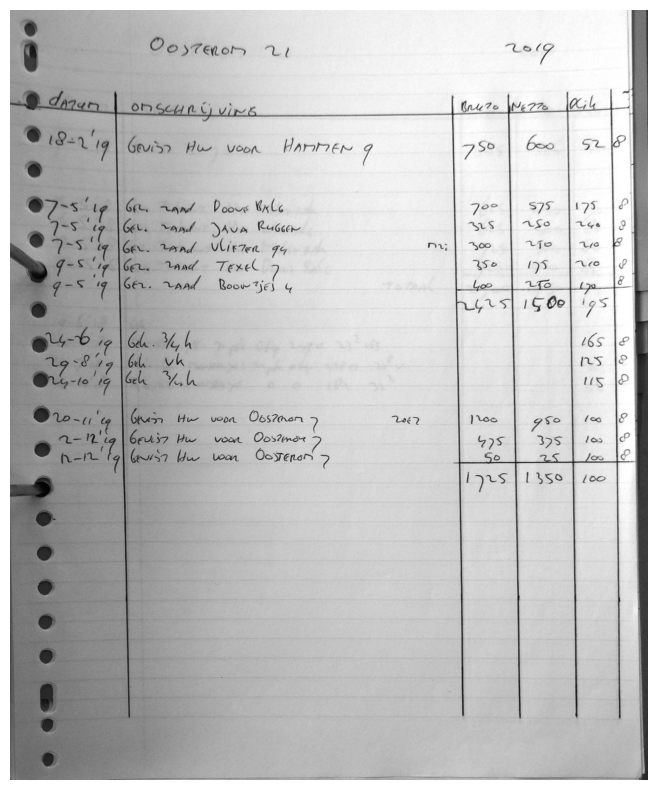

In [74]:
# Load and crop the image before inference
print("Cropping the image with custom padding...")

# Define custom padding values
left_padding = 250   # Large padding on the left to crop out the left side
right_padding = 150    # Standard padding on the right
top_padding = 10      # Standard padding on the top
bottom_padding = 10   # Standard padding on the bottom

# Perform cropping of the image using the custom padding
cropped_image = crop_tables_from_image(
    image=img,
    left_padding=left_padding,
    right_padding=right_padding,
    top_padding=top_padding,
    bottom_padding=bottom_padding
)

# Optional: Print a message indicating cropping is completed
print("Cropping of the image completed.")

# Visualize the cropped image
plt.figure(figsize=(10, 10))  # Set the figure size for better visibility
plt.imshow(cropped_image)     # Display the cropped image
plt.axis('off')               # Hide axes for a cleaner look
plt.show()                    # Render and show the cropped image

### Predict Table Position

#### *Implementation*

In [80]:
# Perform inference on the cropped image
print("Performing inference on the cropped image...")

# Run YOLO inference on the cropped image
results = model_yolo.predict(cropped_image)

# Add a divider before printing detection results
print("=" * 50)  # Divider

# Check and print the number of detected tables
num_tables = len(results[0].boxes)
if num_tables > 0:
    print(f"Detected {num_tables} table(s) in the image.")
else:
    print("No tables detected in the image.")

# Add a divider after printing detection results
print("=" * 50)  # Divider

Performing inference on the cropped image...

0: 640x544 1 bordered, 829.7ms
Speed: 56.4ms preprocess, 829.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 544)
Detected 1 table(s) in the image.


### Visualize Prediction Result

#### *Function*

In [81]:
# Visualize the detection results on the image (bounding boxes from YOLO)
def visualize_inference(image, results):
    """
    Visualize the YOLO inference result by drawing bounding boxes on the image.

    Parameters:
        image (numpy.ndarray): The input image to draw bounding boxes on.
        results: The YOLO results containing detected boxes.
    """
    # Create a copy of the image to draw bounding boxes
    visualized_image = image.copy()

    # Iterate through all detected boxes
    for idx, box in enumerate(results[0].boxes, start=1):
        # Extract bounding box coordinates
        x1, y1, x2, y2 = box.xyxy[0].cpu().int().tolist()

        # Draw bounding box on the image
        visualized_image = cv2.rectangle(visualized_image, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue box

        # Add label for each bounding box
        score = box.conf.cpu().item()  # Confidence score
        cv2.putText(visualized_image, f'Table {idx}: {score:.2f}', (x1, y1 - 10), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)  # Blue text

    return visualized_image

#### *Implementation*

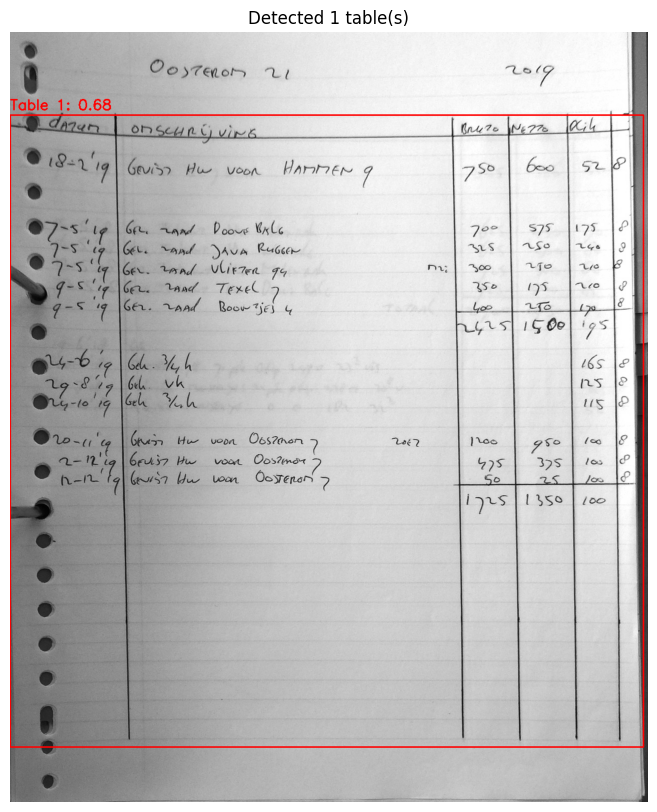

In [82]:
# Get the image with bounding boxes visualized
rendered_image_with_boxes = visualize_inference(cropped_image, results)

# Display the result with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(rendered_image_with_boxes)
plt.axis('off')  # Hide axes for a cleaner look
plt.title(f'Detected {num_tables} table(s)')
plt.show()

### Display Predicted Cropped Table

#### *Function*

In [83]:
def display_cropped_table_by_index(index):
    """
    Display a cropped table image from the list of cropped tables using its index.

    Parameters:
        index (int): The index of the cropped table to display.
    """
    # Step 1: Check if the index is within the valid range of cropped tables
    if not 0 <= index < len(cropped_tables):
        print(f"Error: Index {index} is out of bounds. Available range: 0 to {len(cropped_tables) - 1}.")
        return

    # Step 2: Retrieve the cropped table image by index
    cropped_table = cropped_tables[index]

    # Step 3: Display the cropped table image using matplotlib
    plt.figure(figsize=(5, 5))
    plt.imshow(cropped_table)
    plt.title(f"Displaying Cropped Table {index}")
    plt.axis('off')  # Hide axes for a cleaner presentation
    plt.show()

#### *Implementation*

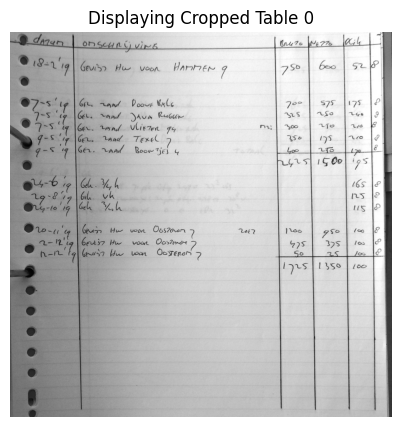

In [84]:
display_cropped_table_by_index(0)

## **Data Post-Processing 1 - Cropped Tables**

### Enhance Cropped Image Quality

#### *Function*

In [89]:
def enhance_cropped_image_quality(image_np):
    """
    Enhance the quality of the image by improving sharpness, contrast, and brightness.

    Parameters:
        image_np (numpy.ndarray): The cropped table image in NumPy array format.

    Returns:
        PIL.Image.Image: The enhanced image.
    """
    # Step 1: Convert the NumPy array to a PIL Image
    image = Image.fromarray(image_np)

    # Step 2: Apply initial sharpening to enhance edges and text
    enhanced_image = image.filter(ImageFilter.SHARPEN)

    # Step 3: Enhance the contrast for better clarity
    contrast_enhancer = ImageEnhance.Contrast(enhanced_image)
    enhanced_image = contrast_enhancer.enhance(1.2)  # Increase contrast by a factor of 1.2

    # Step 4: Enhance the sharpness to make text more visible
    sharpness_enhancer = ImageEnhance.Sharpness(enhanced_image)
    enhanced_image = sharpness_enhancer.enhance(1.5)  # Increase sharpness by a factor of 1.5

    # Step 5: Adjust the brightness if needed
    brightness_enhancer = ImageEnhance.Brightness(enhanced_image)
    enhanced_image = brightness_enhancer.enhance(0.9)  # Slightly increase brightness

    # Step 6: Return the enhanced image
    return enhanced_image

#### *Implementation*

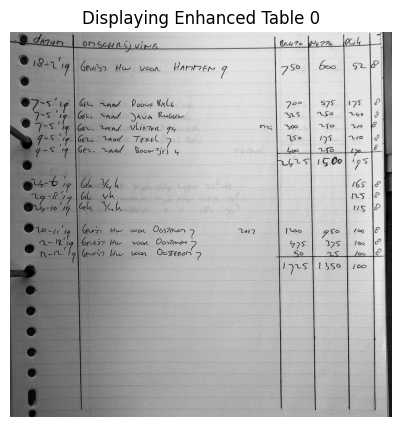

Enhanced images have been updated. Total enhanced tables: 1


In [90]:
# Initialize a list to store the enhanced images
enhanced_tables = []

# Iterate over each cropped table image
for idx, cropped_table in enumerate(cropped_tables):
    # Step 1: Enhance the image quality
    enhanced_image = enhance_cropped_image_quality(cropped_table)
    
    # Step 2: Convert the enhanced image back to a NumPy array and store it
    enhanced_tables.append(np.array(enhanced_image))
    
    # Step 3: Display the enhanced image for verification
    plt.figure(figsize=(5, 5))
    plt.imshow(enhanced_image)
    plt.title(f"Displaying Enhanced Table {idx}")
    plt.axis('off')  # Hide axes for a cleaner look
    plt.show()

# Add a divider for clarity
print("=" * 50)

# Verify that images have been enhanced
print(f"Enhanced images have been updated. Total enhanced tables: {len(enhanced_tables)}")

# Add another divider
print("=" * 50)

## **Modeling 2 - Microsoft Table Transformer**

### Microsoft Table Transformer

#### *Initialize Model*

In [91]:
# Initialize the feature extractor for the Table Transformer model
table_feature_extractor = DetrFeatureExtractor()

# Load the pre-trained Table Transformer model for structure recognition
table_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

d:\Software\Python\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
10/03/2024 12:43:39 - INFO - timm.models._builder -   Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
10/03/2024 12:43:39 - INFO - timm.models._hub -   [timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
10/03/2024 12:43:39 - INFO - timm.models._builder -   Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.
Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbo

#### *Explanation*

The **Table Transformer** model (`TableTransformerForObjectDetection`) is a deep learning model developed by Microsoft for recognizing and extracting table structures from images and documents. It is designed to detect tables and understand their structural components, such as rows and columns, enabling accurate data extraction from complex table layouts.

Key features of the model include:

- **Transformer Architecture**: Utilizes the Transformer encoder-decoder architecture, which excels in capturing global relationships within data.

- **DETR-Based Detection**: Built upon the DEtection TRansformer (DETR) framework, combining convolutional neural networks (CNNs) with Transformers for end-to-end object detection without the need for traditional techniques like non-maximum suppression.

- **Pre-trained Weights**: The model is pre-trained on large datasets for table structure recognition, allowing for immediate use in applications without additional training.

- **Integration with Hugging Face**: Accessible through the Hugging Face Transformers library, facilitating easy deployment and integration into various projects.

#### *Extract Table Label Dictionary*

In [92]:
# Extract the label dictionary from the model configuration
label_dict = table_model.config.id2label

print(label_dict)

{0: 'table', 1: 'table column', 2: 'table row', 3: 'table column header', 4: 'table projected row header', 5: 'table spanning cell'}


Retrieves a dictionary mapping class IDs to class labels from the model's configuration. This is essential for interpreting the model's output, as it tells you what each predicted class ID represents (e.g., table, row, column).

### Plot Predicted Model Results

#### *Defined Colors* 

In [18]:
# Define colors for visualization
COLORS = [
    [0.000, 0.447, 0.741],  # Blue
    [0.850, 0.325, 0.098],  # Orange
    [0.929, 0.694, 0.125],  # Yellow
    [0.494, 0.184, 0.556],  # Purple
    [0.466, 0.674, 0.188],  # Green
    [0.301, 0.745, 0.933],  # Light Blue
]

#### *Function*

In [104]:
def plot_results(pil_img, scores, labels, boxes):
    """
    Plot detection results using Plotly per label category, excluding 'table'.

    Parameters:
        pil_img (PIL.Image.Image): The image on which to plot results.
        scores (torch.Tensor): The detection scores.
        labels (torch.Tensor): The detected labels.
        boxes (torch.Tensor): The bounding boxes for the detected objects.
    """
    # Convert PIL Image to NumPy array
    img_np = np.array(pil_img)

    # Step 1: Create a dictionary to store detections per category, excluding 'table'
    categories = {
        label_name: []
        for _, label_name in label_dict.items()
        if label_name != 'table'
    }

    # Step 2: Organize detections into their respective categories
    for score, label, box in zip(scores.tolist(), labels.tolist(), boxes.tolist()):
        label_name = label_dict.get(label, 'unknown')
        if label_name in categories:
            categories[label_name].append((score, box))

    # Step 3: Filter out categories with no detections
    categories = {cat: dets for cat, dets in categories.items() if dets}

    # Step 4: Check if there are any detections to display
    if not categories:
        print("No detections to display.")
        return

    # Step 5: Initialize the figure with the image
    fig = px.imshow(img_np)

    # Step 6: Add shapes (bounding boxes) for each category with a single color per category
    for idx, (category, detections) in enumerate(categories.items()):
        color = COLORS[idx % len(COLORS)]  # Assign a unique color per category
        x_coords, y_coords = [], []  # Store all x and y coordinates for the same category

        for (score, (xmin, ymin, xmax, ymax)) in detections:
            # Append coordinates for the bounding box
            x_coords += [xmin, xmax, xmax, xmin, xmin, None]  # None is used to break the line between boxes
            y_coords += [ymin, ymin, ymax, ymax, ymin, None]

        # Add a single trace per category with all bounding boxes
        fig.add_trace(go.Scatter(
            x=x_coords,
            y=y_coords,
            mode='lines',
            line=dict(color=f"rgb({color[0]*255},{color[1]*255},{color[2]*255})", width=3),
            name=f'{category}',  # Single label for each category in the legend
            showlegend=True  # Show legend for each label
        ))

    # Step 7: Update layout for legend interaction
    fig.update_layout(
        title="Detected Objects with Interactive Labels",
        xaxis_showgrid=False,
        yaxis_showgrid=False,
        height=img_np.shape[0],
        width=img_np.shape[1],
        legend_title="Detected Categories"
    )

    # Show the interactive plot with legend functionality
    fig.show()

### Detect & Save Predicted Table Results

#### *Function*

In [100]:
def detect_and_save_table_results(enhanced_tables, table_feature_extractor, table_model, threshold=0.4):
    """
    Detect table structures in enhanced images and save the results using Plotly for interactive visualization.

    Parameters:
        enhanced_tables (list): A list of enhanced table images in NumPy array format.
        table_feature_extractor: The feature extractor for the Table Transformer model.
        table_model: The pre-trained Table Transformer model.
        threshold (float): Confidence threshold for detections.

    Returns:
        list: A list of dictionaries containing the image and detection results.
    """
    saved_results = []

    # Step 1: Iterate over each enhanced table image
    for idx, enhanced_image_np in enumerate(enhanced_tables):
        print(f"Processing Table {idx}...")

        try:
            # Step 1a: Convert NumPy array back to PIL Image
            enhanced_image = Image.fromarray(enhanced_image_np)

            # Step 1b: Perform feature extraction on the enhanced image
            encoding = table_feature_extractor(images=enhanced_image, return_tensors="pt")

            # Optional: Print the keys of the encoding result for debugging
            print(f"Encoding keys: {list(encoding.keys())}")

            # Step 1c: Perform inference with the model (disable gradient computation)
            with torch.no_grad():
                outputs = table_model(**encoding)

            # Step 1d: Post-process the outputs for visualization
            # The target size should be the original image size in (height, width)
            target_sizes = [enhanced_image.size[::-1]]  # PIL size is (width, height), so reverse it

            # Obtain detection results above the confidence threshold
            results = table_feature_extractor.post_process_object_detection(
                outputs, threshold=threshold, target_sizes=target_sizes
            )[0]

            # Step 1e: Extract the scores, labels, and bounding boxes
            scores = results['scores']
            labels = results['labels']
            boxes = results['boxes']

            # Step 1f: Save the results in the list
            saved_results.append({
                'image': enhanced_image_np,
                'scores': scores,
                'labels': labels,
                'boxes': boxes
            })

            # Step 1g: Plot the detection results using Plotly for interactive visualization
            if len(scores) > 0:
                plot_results(enhanced_image, scores, labels, boxes)
                print(f"Number of detections: {len(scores)}")
            else:
                print("No detections were made on this table.")

        except Exception as e:
            print(f"An error occurred while processing Table {idx}: {e}")
            # Optionally, you can continue processing the next images or handle the error as needed
            continue

        # Add a divider for readability
        print("=" * 50)

    # Step 2: Return the list of saved results
    return saved_results

#### *Implementation*

In [113]:
saved_table_results = detect_and_save_table_results(enhanced_tables, table_feature_extractor, table_model, 0.99)

Processing Table 0...
Encoding keys: ['pixel_values', 'pixel_mask']


Number of detections: 2


In [134]:
def deskew_image(image, angle=-1):
    """
    Deskew (straighten) an image by rotating it by a given angle.
    
    Parameters:
        image (numpy.ndarray): Input image to be deskewed.
        angle (float): Angle in degrees to rotate the image for deskewing.
                      Default is -1 degree to correct slight rightward skew.
    
    Returns:
        numpy.ndarray: The deskewed (straightened) image.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

def detect_vertical_lines_in_tables(enhanced_tables, min_column_distance=50, left_margin=10):
    """
    Detect vertical lines in enhanced table images, deskew slightly, and visualize bounding boxes for columns.
    
    Parameters:
        enhanced_tables (list): A list of enhanced table images in NumPy array format.
        min_column_distance (int): Minimum distance between columns to consider as separate columns.
        left_margin (int): Extra margin added to the left side of the first column to prevent cutting off content.
    
    Returns:
        None: Visualizes the detected columns with bounding boxes.
    """
    
    for idx, enhanced_image_np in enumerate(enhanced_tables):
        print(f"Processing Table {idx}...")

        try:
            # Step 1: Deskew the image by -1 degree to correct slight skew
            deskewed_image = deskew_image(enhanced_image_np, angle=-1)

            # Convert deskewed image to grayscale
            img_gray = cv2.cvtColor(deskewed_image, cv2.COLOR_RGB2GRAY)

            # Detect edges using Canny edge detector
            edges = cv2.Canny(img_gray, 50, 150, apertureSize=3)

            # Detect vertical lines using Hough Line Transform
            lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=100, maxLineGap=10)

            # Convert image to BGR for visualization
            img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

            # Initialize list for vertical line positions
            vertical_lines = []

            # Collect the positions of vertical lines
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    # Only consider vertical lines
                    if abs(x1 - x2) < 10:  # Threshold to filter only vertical lines
                        vertical_lines.append((x1, y1, x2, y2))

            # If there are detected vertical lines, group them into columns (1 rectangle per column)
            if vertical_lines:
                # Sort lines by their x1 position (left to right)
                vertical_lines = sorted(vertical_lines, key=lambda x: x[0])

                # Merge lines that are too close together into one column
                merged_lines = [vertical_lines[0]]  # Start with the first line
                for i in range(1, len(vertical_lines)):
                    x1_current, _, x2_current, _ = vertical_lines[i]
                    x1_last, _, x2_last, _ = merged_lines[-1]

                    # If the current line is too close to the last merged line, ignore it
                    if abs(x1_current - x1_last) > min_column_distance:
                        merged_lines.append(vertical_lines[i])

                # Draw bounding boxes for each column (from top to bottom)
                for i in range(len(merged_lines) - 1):
                    # Get x positions of the current and next vertical line
                    x1_current, _, x2_current, _ = merged_lines[i]
                    x1_next, _, x2_next, _ = merged_lines[i + 1]

                    # Apply left margin adjustment to the first column
                    if i == 0:
                        x1_current = max(0, x1_current - left_margin)

                    # Draw a rectangle from x1_current to x1_next (create column bounding box)
                    cv2.rectangle(img_color, (x1_current, 0), (x1_next, img_color.shape[0]), (255, 0, 0), 2)

            # Visualize the final result with bounding boxes for columns
            plt.figure(figsize=(12, 12))  # Set larger figure size
            plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
            plt.title(f'Detected Columns for Table {idx}')
            plt.axis('off')  # Hide axes for cleaner visualization
            plt.show()

        except Exception as e:
            print(f"An error occurred while processing Table {idx}: {e}")

Processing Table 0...


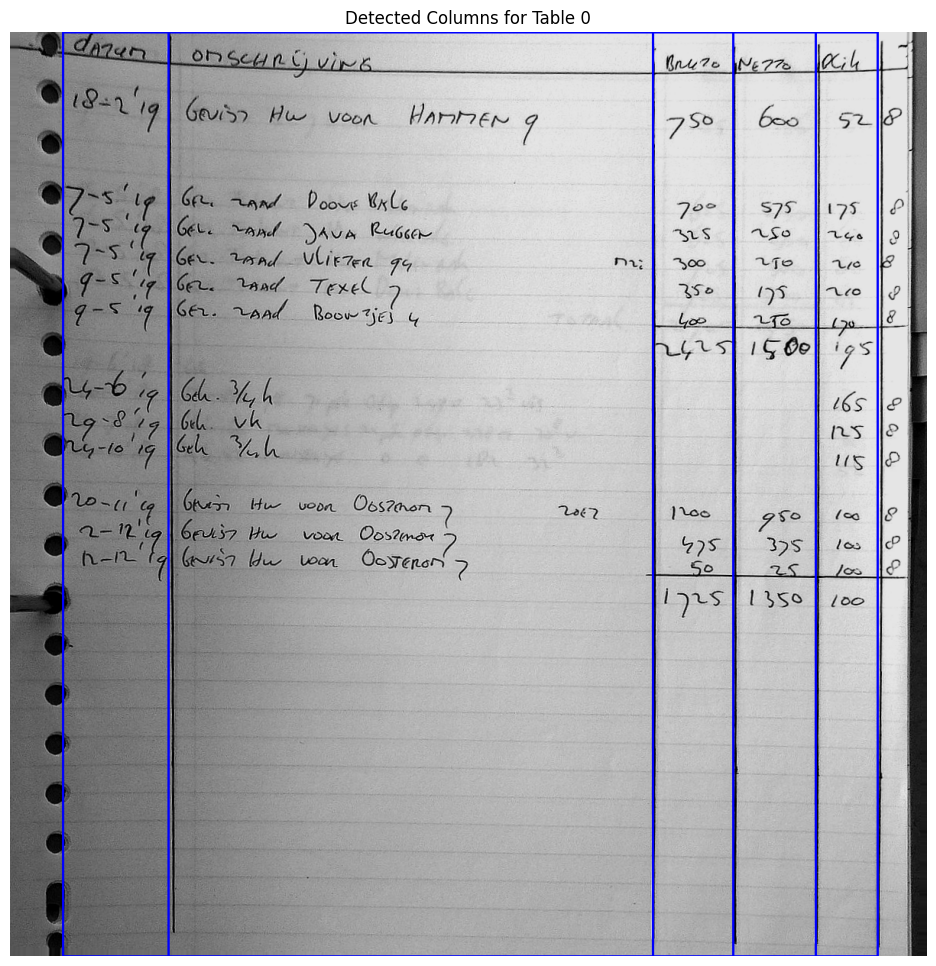

In [137]:
detect_vertical_lines_in_tables(enhanced_tables, min_column_distance=50, left_margin=25)

In [157]:
def deskew_image(image, angle=-1):
    """
    Deskew (straighten) an image by rotating it by a given angle.
    
    Parameters:
        image (numpy.ndarray): Input image to be deskewed.
        angle (float): Angle in degrees to rotate the image for deskewing.
                      Default is -1 degree to correct slight rightward skew.
    
    Returns:
        numpy.ndarray: The deskewed (straightened) image.
    """
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return rotated_image

def detect_horizontal_lines_in_tables(enhanced_tables, min_line_length=150, max_line_length_ratio=0):
    """
    Detect relevant horizontal lines in enhanced table images, ignoring very long lines (such as table headers).
    
    Parameters:
        enhanced_tables (list): A list of enhanced table images in NumPy array format.
        min_line_length (int): Minimum length of horizontal lines to consider as valid rows.
        max_line_length_ratio (float): Maximum ratio of line length to image width for excluding long lines (e.g., table headers).
    
    Returns:
        None: Visualizes the detected rows with bounding boxes.
    """
    
    for idx, enhanced_image_np in enumerate(enhanced_tables):
        print(f"Processing Table {idx}...")

        try:
            # Step 1: Deskew the image by -1 degree to correct slight skew
            deskewed_image = deskew_image(enhanced_image_np, angle=-1)

            # Convert deskewed image to grayscale
            img_gray = cv2.cvtColor(deskewed_image, cv2.COLOR_RGB2GRAY)

            # Apply adaptive thresholding to create a binary image
            _, binary_image = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)

            # Detect horizontal lines using Hough Line Transform
            lines = cv2.HoughLinesP(binary_image, 1, np.pi / 180, threshold=100, minLineLength=min_line_length, maxLineGap=10)

            # Convert image to BGR for visualization
            img_color = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)

            # Define width of the image for filtering out long lines
            image_width = img_color.shape[1]
            max_line_length = image_width * max_line_length_ratio

            # Draw the relevant horizontal lines (ignore long lines, e.g., table headers)
            if lines is not None:
                for line in lines:
                    x1, y1, x2, y2 = line[0]
                    # Only consider horizontal lines and exclude very long lines (like headers)
                    if abs(y1 - y2) < 10 and abs(x2 - x1) < max_line_length:
                        cv2.line(img_color, (x1, y1), (x2, y2), (0, 0, 255), 2)

            # Visualize the final result with bounding boxes for rows
            plt.figure(figsize=(12, 12))  # Set larger figure size
            plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB))
            plt.title(f'Detected Relevant Horizontal Lines (Rows) for Table {idx}')
            plt.axis('off')  # Hide axes for cleaner visualization
            plt.show()

        except Exception as e:
            print(f"An error occurred while processing Table {idx}: {e}")

Processing Table 0...


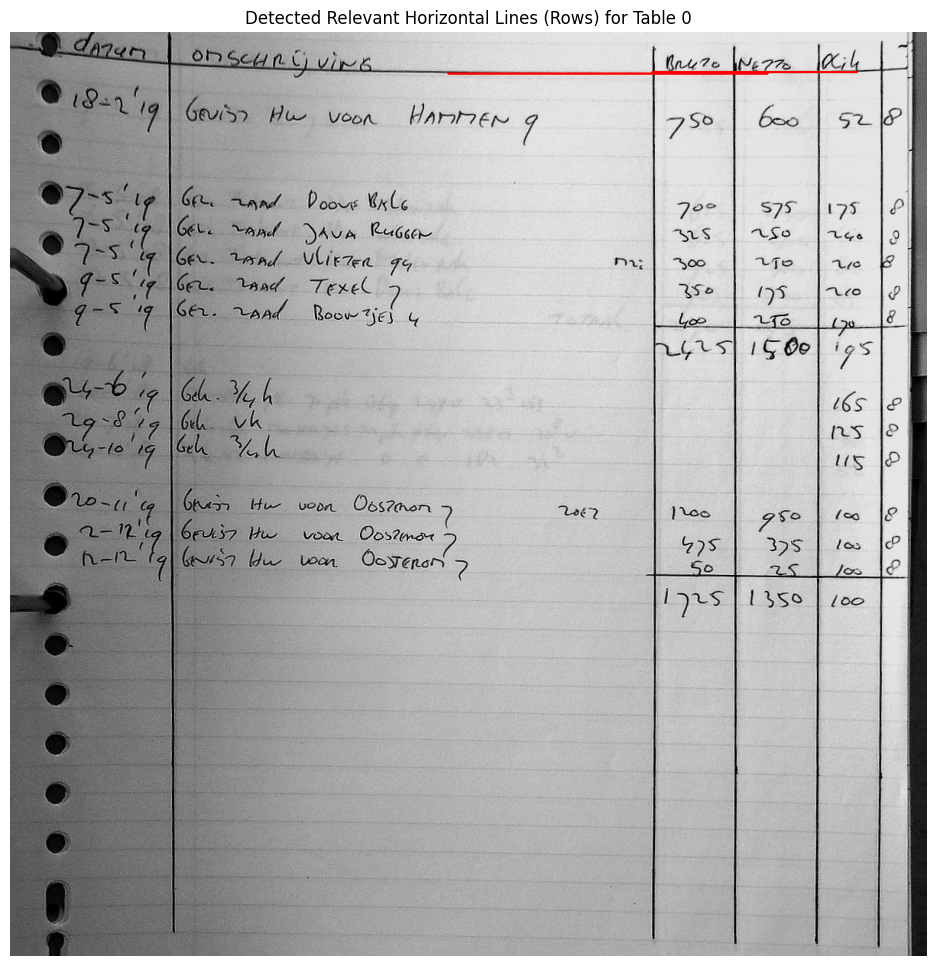

In [163]:
detect_horizontal_lines_in_tables(enhanced_tables, min_line_length=250, max_line_length_ratio=0.35)

### Get Intersection Box

#### *Function*

In [22]:
def get_intersection(box1, box2):
    """
    Calculate the intersection of two bounding boxes.

    Parameters:
        box1 (list or tuple): Coordinates of the first box in the format [x1, y1, x2, y2].
        box2 (list or tuple): Coordinates of the second box in the format [x1, y1, x2, y2].

    Returns:
        list or None: Coordinates of the intersection rectangle [x1, y1, x2, y2] if there is an intersection,
                    otherwise None.
    """
    # Step 1: Calculate the (x, y) coordinates of the intersection rectangle
    x_left   = max(box1[0], box2[0])  # Leftmost x-coordinate of the intersection
    y_top    = max(box1[1], box2[1])  # Topmost y-coordinate of the intersection
    x_right  = min(box1[2], box2[2])  # Rightmost x-coordinate of the intersection
    y_bottom = min(box1[3], box2[3])  # Bottommost y-coordinate of the intersection

    # Step 2: Check if there is an intersection
    if x_left < x_right and y_top < y_bottom:
        # Step 3: Return the coordinates of the intersection rectangle
        return [x_left, y_top, x_right, y_bottom]
    else:
        # Step 4: Return None if there is no intersection
        return None

### Preprocess Image

#### *Function*

In [23]:
def preprocess_image(image):
    """
    Preprocess the input image to enhance it for better OCR or analysis.

    Parameters:
        image (PIL.Image.Image): The input image to preprocess.

    Returns:
        PIL.Image.Image: The preprocessed image.
    """
    # Step 1: Convert PIL Image to a NumPy array and then to an OpenCV image (BGR format)
    cv_image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    
    # Step 2: Convert the BGR image to grayscale
    gray_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY)
    
    # Step 3: Apply adaptive Gaussian thresholding to binarize the image
    threshold_image = cv2.adaptiveThreshold(
        gray_image,                    # Input image
        maxValue=255,                  # Value to assign if condition is satisfied
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # Adaptive thresholding algorithm
        thresholdType=cv2.THRESH_BINARY,                # Thresholding type
        blockSize=11,                  # Size of a pixel neighborhood used to calculate threshold
        C=2                            # Constant subtracted from the mean
    )
    
    # Step 4: Apply Non-Local Means Denoising to reduce noise
    denoised_image = cv2.fastNlMeansDenoising(
        src=threshold_image,           # Input image
        h=10,                          # Filtering strength
        templateWindowSize=7,          # Size of the template patch
        searchWindowSize=21            # Size of the window used for searching similar patches
    )
    
    # Step 5: Convert the denoised image back to a PIL Image
    preprocessed_image = Image.fromarray(denoised_image)
    
    return preprocessed_image

### Clean Text

#### *Function*

In [24]:
def clean_text(text):
    """
    Clean the input text by removing specific characters and unnecessary whitespace.

    Parameters:
        text (str): The text string to be cleaned.

    Returns:
        str: The cleaned text string.
    """
    # Step 1: Remove all '|' characters from the text
    text = text.replace('|', '')
    
    # Step 2: Remove leading and trailing whitespace
    text = text.strip()
    
    # Step 3: Replace multiple consecutive whitespace characters with a single space
    text = re.sub(r'\s+', ' ', text)
    
    return text


### OCR Text from Image

#### *Function*

In [25]:
def extract_text_from_image(image):
    """
    Extract text from an image using OCR after preprocessing.
    Supports Dutch and scientific symbols.

    Parameters:
        image (PIL.Image.Image): The input image from which to extract text.

    Returns:
        str or None: The extracted and cleaned text if any text is found, otherwise None.
    """
    # Step 1: Preprocess the image to enhance text visibility for OCR
    preprocessed_image = preprocess_image(image)
    
    # Step 2: Define custom configuration for Tesseract OCR
    custom_config = r'--oem 3 --psm 6 -l eng'
    # --oem 3: Use the LSTM neural network-based OCR engine
    # --psm 6: Assume a single uniform block of text
    # -l nld+eng: Set the language to Dutch and English

    # Step 3: Use Tesseract to perform OCR on the preprocessed image
    extracted_text = pytesseract.image_to_string(preprocessed_image, config=custom_config).strip()
    
    # Step 4: Clean the extracted text
    cleaned_text = clean_text(extracted_text)
    
    # Step 5: Return the cleaned text if it is not empty
    if cleaned_text:
        return cleaned_text
    else:
        return None

### Extract Column Headers

#### *Function*

In [26]:
def extract_column_headers_with_intersection_and_visualize(saved_result, label_dict):
    """
    Extract column header images and texts by finding intersections between column boxes and header boxes,
    and visualize the results.

    Parameters:
        saved_result (dict): A dictionary containing the image and detection results ('image', 'labels', 'boxes').
        label_dict (dict): A dictionary mapping label IDs to label names.

    Returns:
        tuple:
            header_images (list): List of cropped header images (PIL Images).
            header_texts (list): List of extracted text strings from the header images.
            intersections (list): List of intersection bounding boxes [x1, y1, x2, y2].
    """
    # Step 1: Convert the saved image (NumPy array) back to a PIL Image
    image = Image.fromarray(saved_result['image'])

    # Step 2: Retrieve labels and bounding boxes from the saved results
    labels = saved_result['labels']
    boxes = saved_result['boxes']

    # Step 3: Initialize lists to store header and column bounding boxes
    header_boxes = []
    column_boxes = []

    # Step 4: Separate header and column boxes based on labels
    for label, box in zip(labels.tolist(), boxes.tolist()):
        label_name = label_dict[label]
        if label_name == 'table column header':
            header_boxes.append(box)
        elif label_name == 'table column':
            column_boxes.append(box)

    # Step 5: Check if there are both header and column boxes
    if not header_boxes or not column_boxes:
        print("No headers or columns found in the detection results.")
        return [], [], []

    # Step 6: Sort the column boxes from left to right based on the x-coordinate
    column_boxes.sort(key=lambda x: x[0])

    # Step 7: Find intersections between column boxes and header boxes
    intersections = []
    for column_box in column_boxes:
        for header_box in header_boxes:
            # Get the intersection area between the column and header box
            intersection = get_intersection(column_box, header_box)
            if intersection:
                intersections.append(intersection)

    # Step 8: Sort the intersections from left to right based on the x-coordinate
    intersections.sort(key=lambda x: x[0])

    # Step 9: Initialize lists to store cropped header images and extracted texts
    header_images = []
    header_texts = []

    # Step 10: Crop header images from the intersections and extract text
    for idx, box in enumerate(intersections):
        x1, y1, x2, y2 = map(int, box)  # Convert coordinates to integers
        
        # Crop the intersection area from the image
        cropped_image = image.crop((x1, y1, x2, y2))
        header_images.append(cropped_image)
        
        # Extract text from the cropped header image
        text = extract_text_from_image(cropped_image)
        
        # If no text is extracted or the intersection is empty, use "[Empty]"
        if not text or text.isspace():
            text = "[Empty]"
        
        header_texts.append(text)
        print(f"Extracted text from header {idx}: '{text}'")

    # Handle case where no intersections were found
    if not intersections:
        print("No valid intersections found. Using default column names.")
        num_columns = len(column_boxes)
        header_texts = [f"Column_{i}" for i in range(num_columns)]
        header_images = [Image.new('RGB', (1, 1), color='white') for _ in range(num_columns)]
        intersections = [(0, 0, 1, 1) for _ in range(num_columns)]  # Dummy intersections

    # Step 11: Return the header images, texts, and intersection boxes
    return header_images, header_texts, intersections

### Visualize Intersection Box

#### *Function*

In [27]:
def visualize_intersections(image, intersections):
    """
    Visualize the intersection bounding boxes on the given image.

    Parameters:
        image (PIL.Image.Image): The image on which to draw the intersections.
        intersections (list): A list of intersection bounding boxes in the format [x1, y1, x2, y2].
    """
    # Step 1: Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(20, 10))
    
    # Step 2: Display the image on the axis
    ax.imshow(image)
    
    # Step 3: Iterate over each intersection bounding box
    for idx, box in enumerate(intersections):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        # Step 3a: Create a Rectangle patch for the bounding box
        rect = patches.Rectangle(
            (x1, y1),                # (x, y) position of the rectangle
            width,                   # Width of the rectangle
            height,                  # Height of the rectangle
            linewidth=2,             # Line width of the rectangle edge
            edgecolor='blue',        # Edge color
            facecolor='none'         # No fill color
        )
        
        # Step 3b: Add the rectangle patch to the axis
        ax.add_patch(rect)
        
        # Step 3c: Optionally, add a label or index near the bounding box
        ax.text(
            x1,
            y1 - 5,
            f'Intersection {idx}',
            fontsize=12,
            color='blue',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )
    
    # Step 4: Set the title and remove axes for a cleaner look
    ax.set_title('Column Header Intersections', fontsize=16)
    plt.axis('off')  # Hide the axes
    
    # Step 5: Display the plot
    plt.show()

#### *Implementation*

Processing Table 0...
Extracted text from header 0: '[Empty]'
Extracted text from header 1: '[Empty]'
Extracted text from header 2: '[Empty]'
Extracted text from header 3: '[Empty]'
Extracted text from header 4: '[Empty]'
Extracted text from header 5: '[Empty]'
Extracted 6 column header(s):
  Header 0: '[Empty]'
  Header 1: '[Empty]'
  Header 2: '[Empty]'
  Header 3: '[Empty]'
  Header 4: '[Empty]'
  Header 5: '[Empty]'


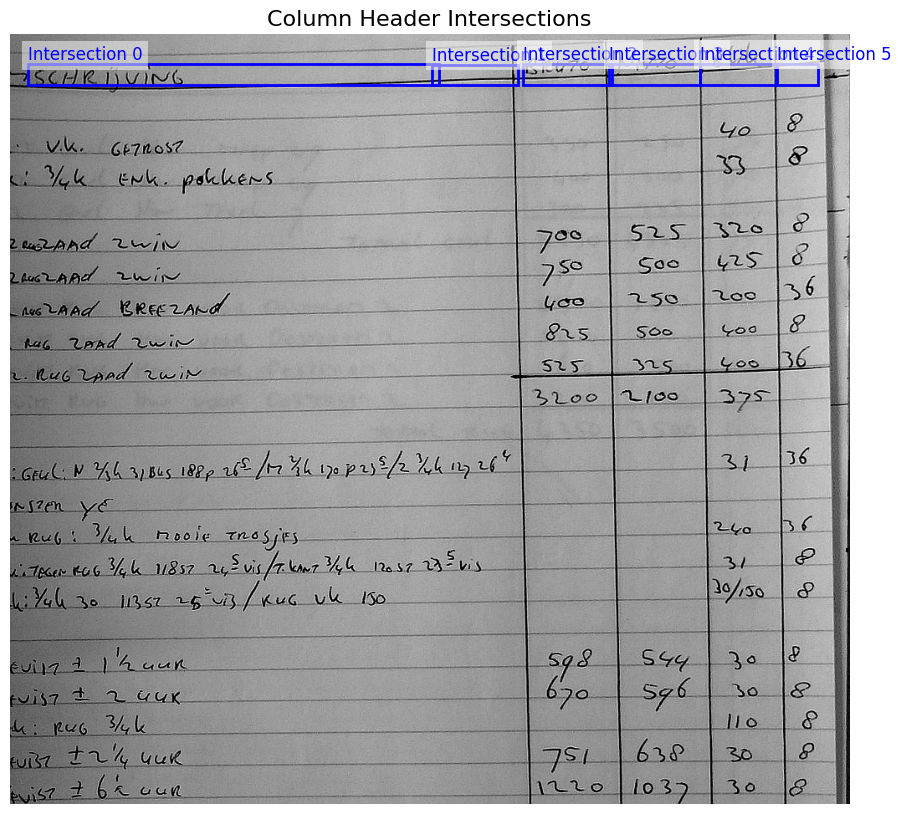

In [28]:
# Initialize lists to store all header images and texts from all tables
all_header_images = []
all_header_texts = []

# Iterate over each saved table result
for idx, result in enumerate(saved_table_results):
    print(f"Processing Table {idx}...")

    # Step 1: Extract column headers using the provided function
    header_images, header_texts, intersections = extract_column_headers_with_intersection_and_visualize(
        saved_result=result,
        label_dict=label_dict
    )
    
    # Step 2: Append the extracted header images and texts to the main lists
    all_header_images.append(header_images)
    all_header_texts.append(header_texts)
    
    # Step 3: Print the number of extracted column headers and their texts
    num_headers = len(header_texts)
    print(f"Extracted {num_headers} column header(s):")
    for i, text in enumerate(header_texts):
        print(f"  Header {i}: '{text}'")
    
    # Step 4: Visualize the intersections on the original image
    image = Image.fromarray(result['image'])
    visualize_intersections(image=image, intersections=intersections)
    
    # Add a divider for readability
    print("=" * 50)


## **Data Post-Processing 2 - Convert to Dataframe**

### Create Dataframe from Headers

#### *Function*

In [29]:
def create_dataframe_from_headers(header_texts):
    """
    Create a pandas DataFrame using the extracted header texts as column names.

    Parameters:
        header_texts (list): A list of header text strings.

    Returns:
        pd.DataFrame: A DataFrame with the header texts as columns.
    """
    # Step 1: Filter out any empty or None strings from the header texts
    valid_headers = [header for header in header_texts if header and header.strip()]
    
    # Step 2: Check if there are any valid headers after filtering
    if not valid_headers:
        # If no valid headers are found, return an empty DataFrame
        print("No valid headers found. Returning an empty DataFrame.")
        return pd.DataFrame()
    
    # Step 3: Create an empty DataFrame with the valid headers as column names
    df = pd.DataFrame(columns=valid_headers)
    
    # Optional: Print a message indicating the DataFrame was created successfully
    print(f"DataFrame created with columns: {valid_headers}")
    
    # Step 4: Return the created DataFrame
    return df

### Process Tables

#### *Function*

In [30]:
def process_tables(saved_table_results, label_dict):
    """
    Process all saved table results to extract headers and create DataFrames.

    Parameters:
        saved_table_results (list): A list of dictionaries containing table detection results.
        label_dict (dict): A dictionary mapping label IDs to label names.

    Returns:
        list: A list of pandas DataFrames created from the extracted headers.
    """
    # Initialize a list to store DataFrames for all tables
    all_dataframes = []

    # Iterate over each saved table result
    for idx, result in enumerate(saved_table_results):
        print(f"Processing Table {idx}...")

        # Step 1: Extract column headers and intersections
        header_images, header_texts, intersections = extract_column_headers_with_intersection_and_visualize(
            saved_result=result,
            label_dict=label_dict
        )

        # Step 2: Print the extracted headers
        num_headers = len(header_texts)
        print(f"Extracted {num_headers} column header(s):")
        for i, text in enumerate(header_texts):
            print(f"  Header {i}: '{text}'")

        # Step 3: Create a DataFrame using the extracted headers
        df = create_dataframe_from_headers(header_texts)
        all_dataframes.append(df)

        # Step 4: Print information about the created DataFrame
        print(f"Created DataFrame with shape: {df.shape}")
        print(df.head())  # Display the first few rows (empty at this point)
        print("=" * 50 + "\n")

    # Return the list of DataFrames
    return all_dataframes

#### *Implementation*

In [31]:
all_dataframes = process_tables(saved_table_results, label_dict)

Processing Table 0...
Extracted text from header 0: '[Empty]'
Extracted text from header 1: '[Empty]'
Extracted text from header 2: '[Empty]'
Extracted text from header 3: '[Empty]'
Extracted text from header 4: '[Empty]'
Extracted text from header 5: '[Empty]'
Extracted 6 column header(s):
  Header 0: '[Empty]'
  Header 1: '[Empty]'
  Header 2: '[Empty]'
  Header 3: '[Empty]'
  Header 4: '[Empty]'
  Header 5: '[Empty]'
DataFrame created with columns: ['[Empty]', '[Empty]', '[Empty]', '[Empty]', '[Empty]', '[Empty]']
Created DataFrame with shape: (0, 6)
Empty DataFrame
Columns: [[Empty], [Empty], [Empty], [Empty], [Empty], [Empty]]
Index: []



In [32]:
def post_process_cell_text(text, column_index):
    if column_index in [1, 2, 3, 4]:  # Columns likely to contain numbers
        # Remove non-digit characters
        text = ''.join(filter(str.isdigit, text))
        # Convert empty string to '0' or keep as is
        text = text if text else '0'
    return text

In [33]:
def fill_dataframe_with_rows(df, result, label_dict):
    image = Image.fromarray(result['image'])
    labels = result['labels']
    boxes = result['boxes']

    column_boxes = [box for label, box in zip(labels.tolist(), boxes.tolist()) if label_dict[label] == 'table column']
    row_boxes = [box for label, box in zip(labels.tolist(), boxes.tolist()) if label_dict[label] == 'table row']

    # Sort column boxes from left to right
    column_boxes.sort(key=lambda x: x[0])
    # Sort row boxes from top to bottom
    row_boxes.sort(key=lambda x: x[1])

    # Skip the first row box as it's likely the header
    if row_boxes:
        row_boxes = row_boxes[1:]

    all_intersections = []

    for row_box in row_boxes:
        row_data = []
        for col_box in column_boxes:
            cell_box = get_intersection(row_box, col_box)
            if cell_box:
                all_intersections.append(cell_box)
                cell_image = image.crop(cell_box)
                cell_text = extract_text_from_image(cell_image)
                row_data.append(cell_text if cell_text else "")
            else:
                row_data.append("")

        # Ensure row_data matches the number of columns
        if len(row_data) < len(df.columns):
            row_data.extend([""] * (len(df.columns) - len(row_data)))
        elif len(row_data) > len(df.columns):
            row_data = row_data[:len(df.columns)]

        df.loc[len(df)] = row_data

    # Visualize the intersections
    visualize_intersections(image, all_intersections)

    return df

In [34]:
def visualize_intersections(image, intersections):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.imshow(image)
    
    for idx, box in enumerate(intersections):
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        
        rect = patches.Rectangle(
            (x1, y1),
            width,
            height,
            linewidth=2,
            edgecolor='blue',
            facecolor='none'
        )
        ax.add_patch(rect)
        
        ax.text(
            x1,
            y1 - 5,
            f'Cell {idx}',
            fontsize=8,
            color='blue',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
        )
    
    ax.set_title('Table Cell Intersections', fontsize=16)
    plt.axis('off')
    plt.show()

In [35]:
def fill_all_dataframes(all_dataframes, saved_table_results, label_dict):
    filled_dataframes = []
    
    for df, result in zip(all_dataframes, saved_table_results):
        print(f"Filling DataFrame for Table {len(filled_dataframes)}")
        filled_df = fill_dataframe_with_rows(df.copy(), result, label_dict)
        filled_dataframes.append(filled_df)
        
        print(f"Filled DataFrame with shape: {filled_df.shape}")
        print(filled_df)
        print("\n" + "="*50 + "\n")
    
    return filled_dataframes

In [36]:
# Usage
filled_dataframes = fill_all_dataframes(all_dataframes, saved_table_results, label_dict)

Filling DataFrame for Table 0


KeyboardInterrupt: 

---

In [38]:
dictionary = ['Defence', 'Police', 'Total', 'Country', 'Year', 'Amount', 'Population', 'Students', 'CEOs', 'Dimensions']

In [ ]:
Totol

In [39]:
def cer(s1, s2):
    """
    Compute the Character Error Rate (CER) between two strings.
    
    Parameters:
    s1 (str): First string (OCR result).
    s2 (str): Second string (valid word).

    Returns:
    float: The CER score (lower is better).
    """
    # Compute the Levenshtein distance (edit distance)
    distance = difflib.SequenceMatcher(None, s1, s2).ratio()
    
    # Return CER as 1 - similarity ratio
    return 1 - distance

In [40]:
def get_best_match_by_cer(word, valid_words):
    """
    Find the closest match for a word from a list of valid words using CER (Character Error Rate).

    Parameters:
    word (str): The OCR-extracted word to match.
    valid_words (list): The list of valid words to match against.

    Returns:
    str: The valid word with the highest similarity percentage, or the original word if no close match is found.
    """
    # Calculate CER for each valid word
    cer_scores = []
    for valid_word in valid_words:
        score = cer(word, valid_word)  # CER gives a value between 0 and 1, lower is better
        cer_scores.append((valid_word, score))

    # Find the best match with the minimum CER (i.e., the most similar word)
    best_match = min(cer_scores, key=lambda x: x[1])
    
    # Convert CER to percentage match (100% is identical, lower is less similar)
    similarity_percentage = (1 - best_match[1]) * 100

    # Print the best match and the similarity percentage
    print(f"Best match: '{best_match[0]}' with similarity: {similarity_percentage:.2f}%")

    # Return the best match if the similarity is above a threshold (e.g., 50%), otherwise return the original word
    return best_match[0] if similarity_percentage > 50 else word

In [41]:
# Dictionary to store the resulting DataFrames for each table
table_dataframes = {}

# Iterate over the extracted table data and apply OCR to extract column names
for table_name, table_info in table_data.items():
    print(f"\nExtracting column headers for: {table_name}")

    if table_info['column_header'] is not None:
        # Perform OCR on the column header image using pytesseract
        ext_df = pytesseract.image_to_data(table_info['column_header'], output_type=Output.DATAFRAME, config="--psm 1")
        
        # Clean up the OCR results: drop rows without text
        ext_df = ext_df.dropna(subset=['text'])
        
        # Ensure all entries in the 'text' column are strings
        ext_df['text'] = ext_df['text'].astype(str)

        # Strip whitespace from the 'text' column and remove very short entries
        ext_df['text'] = ext_df['text'].str.strip()
        ext_df = ext_df[ext_df['text'].apply(len) > 1]
        ext_df = ext_df.reset_index(drop=True)

        # Extract the column names and find the closest match using CER
        extracted_columns = ext_df['text'].apply(lambda x: get_best_match_by_cer(x, dictionary)).values.tolist()

        # Create a DataFrame for this table with the extracted column names
        ext_result_df = pd.DataFrame(columns=list(map(lambda x: x, range(len(extracted_columns)))))
        ext_result_df.columns = extracted_columns

        # Store the DataFrame in the dictionary with the table name as the key
        table_dataframes[table_name] = ext_result_df

        # Dynamically create a variable for each table DataFrame
        globals()[f'{table_name}_df'] = ext_result_df

        # Print the resulting DataFrame with the extracted column headers
        print(f"Extracted column names for {table_name}: {extracted_columns}")
        print(ext_result_df)
    else:
        print(f"No column header found for {table_name}")

NameError: name 'table_data' is not defined